# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# from ssd import build_ssd

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [2]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('../weights/pretrained/ssd300_mAP_77.43_v2.pth')

NameError: name 'build_ssd' is not defined

## Load Image 
### Here we just load a sample image from the VOC07 dataset 

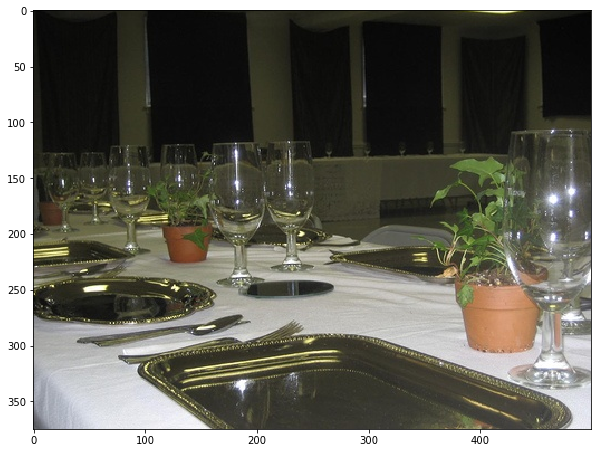

In [46]:
# image = cv2.imread('./data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
%matplotlib inline
from matplotlib import pyplot as plt
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
testset = VOCDetection(VOC_ROOT, [('2007', 'val')], None, VOCAnnotationTransform())
img_id = 2018
image = testset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values, 
and swap the color channels for input to SSD300.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


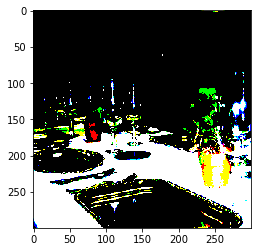

In [47]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from layers import *
from data import voc, coco
import os


class SSD(nn.Module):
    """Single Shot Multibox Architecture
    The network is composed of a base VGG network followed by the
    added multibox conv layers.  Each multibox layer branches into
        1) conv2d for class conf scores
        2) conv2d for localization predictions
        3) associated priorbox layer to produce default bounding
           boxes specific to the layer's feature map size.
    See: https://arxiv.org/pdf/1512.02325.pdf for more details.

    Args:
        phase: (string) Can be "test" or "train"
        size: input image size
        base: VGG16 layers for input, size of either 300 or 500
        extras: extra layers that feed to multibox loc and conf layers
        head: "multibox head" consists of loc and conf conv layers
    """

    def __init__(self, phase, size, base, extras, head, num_classes):
        super(SSD, self).__init__()
        self.phase = phase
        self.num_classes = num_classes
        self.cfg = (coco, voc)[num_classes == 21]
        self.priorbox = PriorBox(self.cfg)
        self.priors = Variable(self.priorbox.forward())
        self.size = size

        # SSD network
        self.vgg = nn.ModuleList(base)
        # Layer learns to scale the l2 normalized features from conv4_3
        self.L2Norm = L2Norm(512, 20)
        self.extras = nn.ModuleList(extras)

        self.loc = nn.ModuleList(head[0])
        self.conf = nn.ModuleList(head[1])

        if phase == 'test':
            self.softmax = nn.Softmax(dim=-1)
            self.detect = Detect(num_classes, 0, 200, 0.01, 0.45)

    def forward(self, x):
        """Applies network layers and ops on input image(s) x.

        Args:
            x: input image or batch of images. Shape: [batch,3,300,300].

        Return:
            Depending on phase:
            test:
                Variable(tensor) of output class label predictions,
                confidence score, and corresponding location predictions for
                each object detected. Shape: [batch,topk,7]

            train:
                list of concat outputs from:
                    1: confidence layers, Shape: [batch*num_priors,num_classes]
                    2: localization layers, Shape: [batch,num_priors*4]
                    3: priorbox layers, Shape: [2,num_priors*4]
        """
        sources = list()
        loc = list()
        conf = list()

        # apply vgg up to conv4_3 relu
        for k in range(23):
            x = self.vgg[k](x)

        s = self.L2Norm(x)
        sources.append(s)

        # apply vgg up to fc7
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)
            
        sources.append(x)

        # apply extra layers and cache source layer outputs
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:
                sources.append(x)

        # apply multibox head to source layers
        for (x, l, c) in zip(sources, self.loc, self.conf):
            print(x.shape)
            plt.imshow(x.squeeze(0)[0:3,:,:].permute(1, 2, 0).cpu().detach().numpy()/x.max().cpu().detach().numpy())
            plt.show()
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())

        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)
        if self.phase == "test":
            output = self.detect(
                loc.view(loc.size(0), -1, 4),                   # loc preds
                self.softmax(conf.view(conf.size(0), -1,
                             self.num_classes)),                # conf preds
                self.priors.type(type(x.data))                  # default boxes
            )
        else:
            output = (
                loc.view(loc.size(0), -1, 4),
                conf.view(conf.size(0), -1, self.num_classes),
                self.priors
            )
        return output

    def load_weights(self, base_file):
        other, ext = os.path.splitext(base_file)
        if ext == '.pkl' or '.pth':
            print('Loading weights into state dict...')
            self.load_state_dict(torch.load(base_file,
                                 map_location=lambda storage, loc: storage))
            print('Finished!')
        else:
            print('Sorry only .pth and .pkl files supported.')


# This function is derived from torchvision VGG make_layers()
# https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
def vgg(cfg, i, batch_norm=False):
    layers = []
    in_channels = i
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'C':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return layers


def add_extras(cfg, i, batch_norm=False):
    # Extra layers added to VGG for feature scaling
    layers = []
    in_channels = i
    flag = False
    for k, v in enumerate(cfg):
        if in_channels != 'S':
            if v == 'S':
                layers += [nn.Conv2d(in_channels, cfg[k + 1],
                           kernel_size=(1, 3)[flag], stride=2, padding=1)]
            else:
                layers += [nn.Conv2d(in_channels, v, kernel_size=(1, 3)[flag])]
            flag = not flag
        in_channels = v
    return layers


def multibox(vgg, extra_layers, cfg, num_classes):
    loc_layers = []
    conf_layers = []
    vgg_source = [21, -2]
    for k, v in enumerate(vgg_source):
        loc_layers += [nn.Conv2d(vgg[v].out_channels,
                                 cfg[k] * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(vgg[v].out_channels,
                        cfg[k] * num_classes, kernel_size=3, padding=1)]
    for k, v in enumerate(extra_layers[1::2], 2):
        loc_layers += [nn.Conv2d(v.out_channels, cfg[k]
                                 * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(v.out_channels, cfg[k]
                                  * num_classes, kernel_size=3, padding=1)]
    return vgg, extra_layers, (loc_layers, conf_layers)


base = {
    '300': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M',
            512, 512, 512],
    '512': [],
}
extras = {
    '300': [256, 'S', 512, 128, 'S', 256, 128, 256, 128, 256],
    '512': [],
}
mbox = {
    '300': [4, 6, 6, 6, 4, 4],  # number of boxes per feature map location
    '512': [],
}

In [49]:
def build_ssd(phase, size=300, num_classes=21):
    if phase != "test" and phase != "train":
        print("ERROR: Phase: " + phase + " not recognized")
        return
    if size != 300:
        print("ERROR: You specified size " + repr(size) + ". However, " +
              "currently only SSD300 (size=300) is supported!")
        return
    base_, extras_, head_ = multibox(vgg(base[str(size)], 3),
                                     add_extras(extras[str(size)], 1024),
                                     mbox[str(size)], num_classes)
    return SSD(phase, size, base_, extras_, head_, num_classes)

In [50]:
net = build_ssd('test', 300, 21)    # initialize SSD
# print(net)
net.load_weights('../weights/pretrained/ssd300_mAP_77.43_v2.pth')

Loading weights into state dict...
Finished!


torch.Size([1, 512, 38, 38])


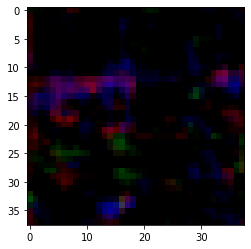

torch.Size([1, 1024, 19, 19])


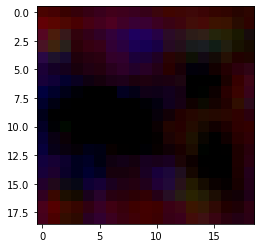

torch.Size([1, 512, 10, 10])


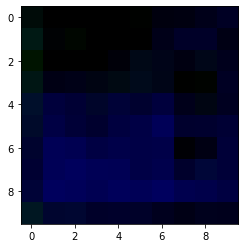

torch.Size([1, 256, 5, 5])


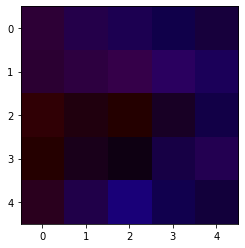

torch.Size([1, 256, 3, 3])


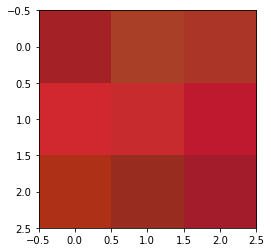

torch.Size([1, 256, 1, 1])


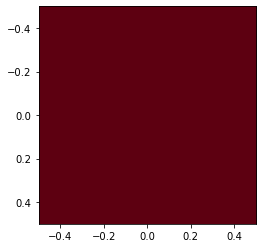

In [51]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

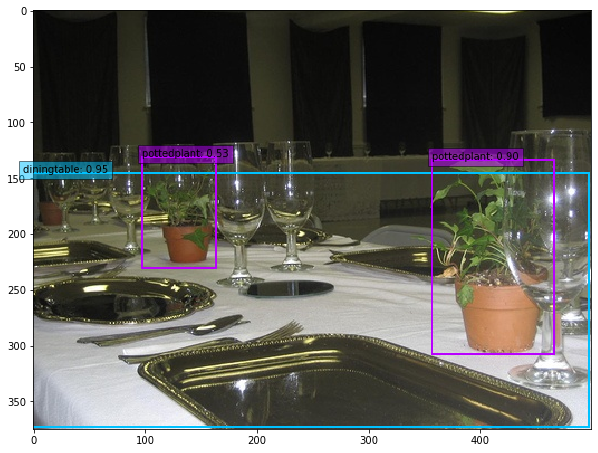

In [56]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.5:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1